<a href="https://colab.research.google.com/github/Nanase1994/BA810/blob/main/Lab10_DecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 10: Decision Trees

In this lab we continue with the prediction task from the previous lab: predicting the brand of orange juice a customer will purchase based on a number of customer and product information.

We'll use the [`OJ.csv` dataset](https://www.rdocumentation.org/packages/ISLR2/versions/1.3-1/topics/OJ). You can get the data file from [our course data folder](https://drive.google.com/drive/folders/1YBxtx7KILtcw6mFEkKmznaRASUHPLjI2?usp=sharing).

The data set has the following columns:

1. `Purchase` (the **target**): A categorical variable with levels CH and MM indicating whether the customer purchased Citrus Hill or Minute Maid Orange Juice
1. `WeekofPurchase`: Week of purchase
1. `StoreID`: Store ID
1. `PriceCH`: Price charged for CH
1. `PriceMM`: Price charged for MM
1. `DiscCH`: Discount offered for CH
1. `DiscMM`: Discount offered for MM
1. `SpecialCH`: Indicator of special on CH
1. `SpecialMM`: Indicator of special on MM
1. `LoyalCH`: Customer brand loyalty for CH
1. `SalePriceMM`: Sale price for MM
1. `SalePriceCH`: Sale price for CH
1. `PriceDiff`: Sale price of MM less sale price of CH
1. `Store7`: A categorical variable with levels No and Yes indicating whether the sale is at Store 7
1. `PctDiscMM`: Percentage discount for MM
1. `PctDiscCH`: Percentage discount for CH
1. `ListPriceDiff`: List price of MM less list price of CH
1. `STORE`: Which of 5 possible stores the sale occured at


The broad outline of the lab is as follows:

1. Explore, clean, and split the dataset
1. Learn and examine a small decision tree classifier
1. Learn a full tree and prune it to maximize CV accuracy
1. Apply the optimum tree to the test data to estimate out of sample error


## Load, clean, and split dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# drive_url = 'https://drive.google.com/file/d/1YiwMCQSxfD4ZVKCPzHUNl5ocdcvYXeZd/view?usp=drive_link'
file_url = 'https://drive.google.com/uc?id=1YiwMCQSxfD4ZVKCPzHUNl5ocdcvYXeZd'
rawdata = pd.read_csv(file_url)
rawdata.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,No,0.000000,0.000000,0.00,1
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,Yes,0.000000,0.000000,0.00,0


We are carrying out some basic cleaning below as before: converting some of the variables into category type and dropping some columns with same information, primarily for ease of interpretation of the resulting tree. See previous Lab for more discussion of this.

In [2]:
data = rawdata.astype({'Purchase': 'category', 'StoreID':'category', 'SpecialCH':'category', 'SpecialMM':'category', })
data.drop(['Store7', 'STORE'], axis=1, inplace=True) # drop columns with same/similar information
data.info() # check data
print(data['Purchase'].value_counts()) # check class distribution
data.head() # take a look at the top 5 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Purchase        1070 non-null   category
 1   WeekofPurchase  1070 non-null   int64   
 2   StoreID         1070 non-null   category
 3   PriceCH         1070 non-null   float64 
 4   PriceMM         1070 non-null   float64 
 5   DiscCH          1070 non-null   float64 
 6   DiscMM          1070 non-null   float64 
 7   SpecialCH       1070 non-null   category
 8   SpecialMM       1070 non-null   category
 9   LoyalCH         1070 non-null   float64 
 10  SalePriceMM     1070 non-null   float64 
 11  SalePriceCH     1070 non-null   float64 
 12  PriceDiff       1070 non-null   float64 
 13  PctDiscMM       1070 non-null   float64 
 14  PctDiscCH       1070 non-null   float64 
 15  ListPriceDiff   1070 non-null   float64 
dtypes: category(4), float64(11), int64(1)
memory usage: 105.2 KB

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,PctDiscMM,PctDiscCH,ListPriceDiff
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.500000,1.99,1.75,0.24,0.000000,0.000000,0.24
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.600000,1.69,1.75,-0.06,0.150754,0.000000,0.24
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.680000,2.09,1.69,0.40,0.000000,0.091398,0.23
3,MM,227,1,1.69,1.69,0.00,0.0,0,0,0.400000,1.69,1.69,0.00,0.000000,0.000000,0.00
4,CH,228,7,1.69,1.69,0.00,0.0,0,0,0.956535,1.69,1.69,0.00,0.000000,0.000000,0.00


Separate the X from y and split them into training and testing.

In [3]:
from sklearn.model_selection import train_test_split
X = data.drop('Purchase', axis=1) # separate X ...
y = data['Purchase'].copy()       # from y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42) #split all
X_train.shape, X_test.shape, y_train.shape, y_test.shape # check sizes

((856, 15), (214, 15), (856,), (214,))

## Learn and examine a decision tree classifier


Decision trees generally require less preprocessing: they can seemlessly work with missing values, don't require expansion of categorical variables, and since values of two columns are rarely compared, don't require normalization. However, the `sklearn` implementation doesn't have all these advantages. For example, it'd fail with missing or categorical features. So, we'll need some preprocessing.

The pipeline is similar to what we have always done. However, we'll deviate from our standard practice of applying the entire pipeline to the training data. We'll apply only the preprocessing steps to prepare the data that we'll then use to learn and prune decision trees.

Part of the reason is that the cost complexity pruning routine we have can't be directly used inside the pipeline.


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn import set_config
set_config(display='diagram') # shows the pipeline graphically when printed

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
    ])
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('cat_encoder', OneHotEncoder(sparse_output=False))
    ])

prep_pipeline = ColumnTransformer([
    ('num', num_pipeline, make_column_selector(dtype_include=np.number)),
    ('cat', cat_pipeline, make_column_selector(dtype_include='category'))
], verbose_feature_names_out=False) # don't prepend the column names with step labels (cleaner)
prep_pipeline.set_output(transform='pandas') # output as a pandas dataframe instead of numpy array

# We apply the preprocessing as a separate step and work with the transformed data
X_train_prepd = prep_pipeline.fit_transform(X_train)

# preprocess the X_test as well
X_test_prepd = prep_pipeline.transform(X_test)


This is a classification task: we are predicting whether the customer will buy `CH` or `MM` brand. So, we'll learn a `DecisionTreeClassifier`. We'll construct a small tree, stopping after the depth has reached 3, for ease of inspection.

`max_depth` is only one of many arguments to limit the growth of a tree (control complexity, thus variance and overfitting, by incurring some bias). We use this because it most directly controls the look/structure of the tree (how tall we want it to be).

Other arguments include:

1. `min_samples_split`: smallest node that can be split
1. `min_samples_leaf`: smallest leaf that can result
1. `max_leaf_nodes`: maximum number of leaf nodes allowed
1. `min_impurity_decrease`: impurity must decrease at least this fraction to split
1. `ccp_alpha`: cost complexity pruning alpha parameter (higher → smaller tree)

['CH' 'MM']


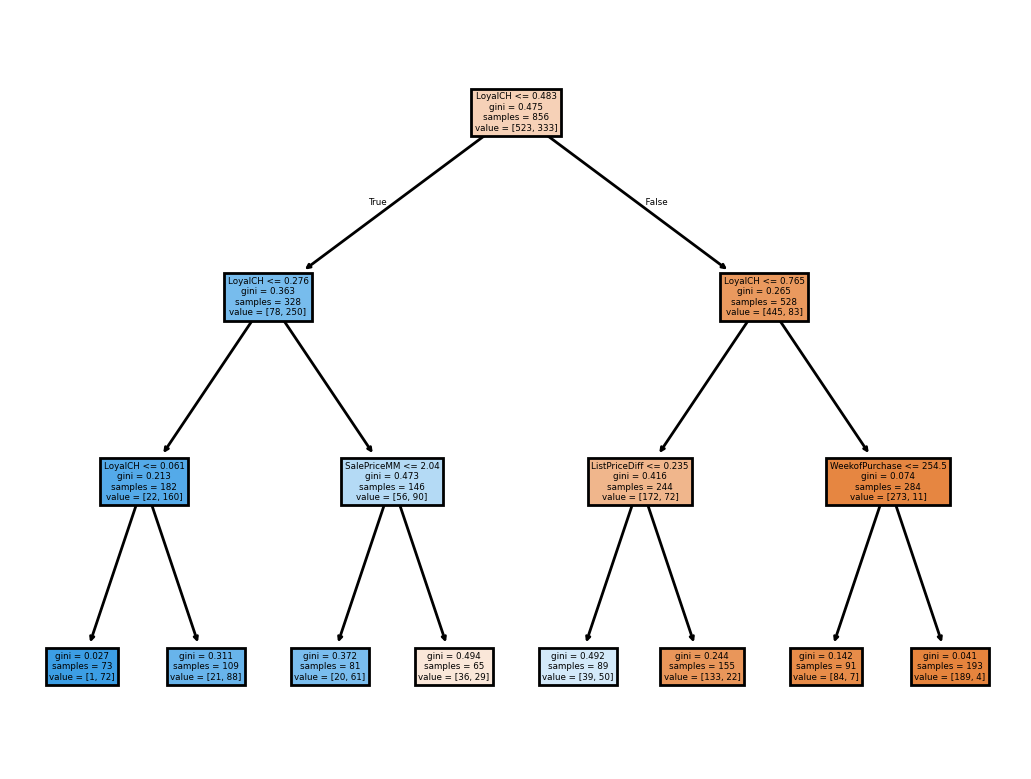

In [5]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import make_pipeline

clf = DecisionTreeClassifier(max_depth=3) # maximum of three layers after root (layer 0).

clf.fit(X_train_prepd, y_train)
print(clf.classes_) # To check order of the two classes
plt.figure(dpi=200) # Makes the figure a little larger, easier to read
plot_tree(clf, filled=True, feature_names=list(X_train_prepd.columns)); # graphically shows the tree

This tree packs a lot of information within each node. Let's go through them one at a time:
1. color: varies from dark blue (most likely to be MM) to dark orange (likely to be CH)
1. inequality on first line: condition if true, follow left branch, else follow right branch
1. `gini`: Gini inequality/impurity index of the node (lower: clearer prediction)
1. `samples`: number of records in this node (that meet all the conditions on the path to reach this node)
1. `value`: numbers of records from each class in this node

The tree learning algorithm can track the total reduction in impurity (Gini or MSE) brought by each feature. This as a fraction of total reduction in impurity from the root to the leaves can be interpreted as a measure of the importance of the feature for predicting the outcome. We can access it through the `feature_importances_` property of a fitted decision tree.

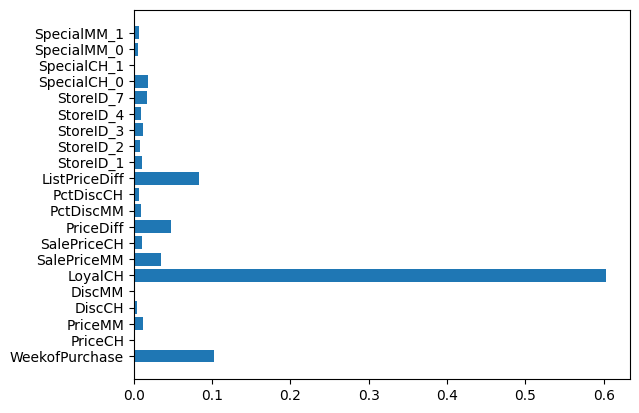

In [6]:
full_tree = DecisionTreeClassifier(random_state=0)
  # Learn a full tree so that we can get importances of all features.
full_tree.fit(X_train_prepd, y_train)
feature_importances = full_tree.feature_importances_
feature_names = prep_pipeline.get_feature_names_out()
plt.barh(feature_names, feature_importances);

## Prune the tree

We constructed a tree of depth 3 above largely so that we have a manageable sized tree to examine. But, we have no idea whether that tree will predict well. To arrive at the "best" tree for prediction, let's use cost-complexity-pruning. It turns out that as we increase the value of regularization parameter ($α$), the tree gradually shrinks (tree for a higher value of $α$ is a strct subset of the tree before). There is a convenience routine that gives us all the $α$'s (steps) at which the tree reduces:

There are 76 alpha values.


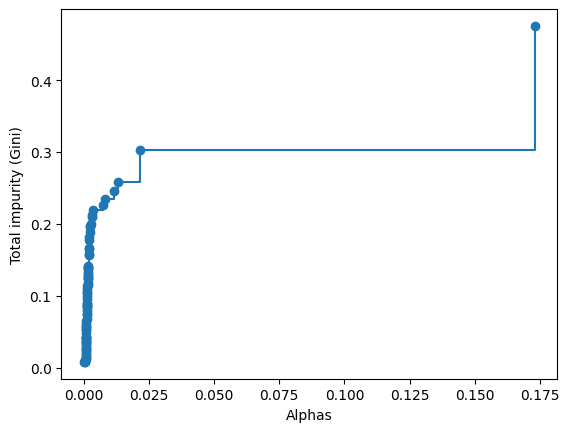

In [7]:
clf_full = DecisionTreeClassifier(random_state=0)
path = clf_full.cost_complexity_pruning_path(X_train_prepd, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities # default impurity is Gini
plt.plot(ccp_alphas, impurities, marker='o', drawstyle='steps-post')
plt.xlabel('Alphas'); plt.ylabel('Total impurity (Gini)');

print(f'There are {ccp_alphas.shape[0]} alpha values.')

At $α=0$ we have no pruning: the leaves will contain primarily one of the two classes, so low gini impurity index. At the largest $α$ value, we have the gini of the original training data (without any split), therefore, high gini impurity index. We can also plot the number of nodes in and the depth of the tree against $α$, to see how the size of the tree changes with $α$:

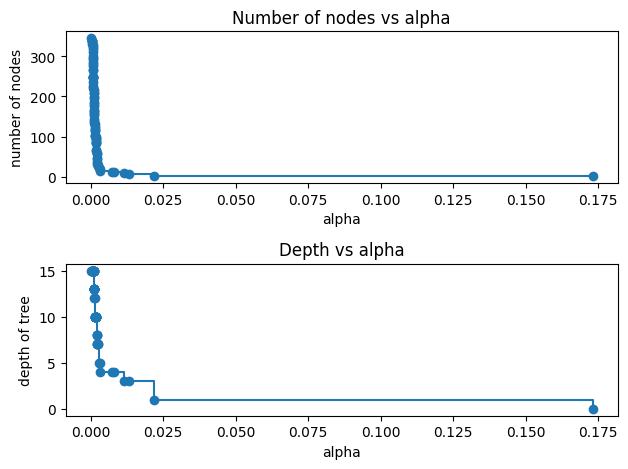

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf_i = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_i.fit(X_train_prepd, y_train)
    clfs.append(clf_i)

node_counts = [clf_i.tree_.node_count for clf_i in clfs]
depth = [clf_i.tree_.max_depth for clf_i in clfs]

fig, ax = plt.subplots(2, 1, dpi=100)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

The trees get smaller as $α$ increases. But which one of those ≈70 trees predicts best? We can use a cross validation with grid search to find the best among the identified $\alpha$s:

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'ccp_alpha': ccp_alphas}  # Just one parameter, no pipeline steps, thus no __ syntax.

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
  # We start with a "blank" tree, without any max_depth or other parameters.
  # We'll control the size of the tree only via the alpha parameter.
  # We could have tuned a pipeline containing preprocessing followed by a decision tree. Then we
  # could apply the best model directly to the test set.
grid_search.fit(X_train_prepd, y_train)

# Display
grid_cv_res = pd.DataFrame(grid_search.cv_results_)
grid_cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
display(grid_cv_res.filter(regex = '(^param_|mean_test_score)', axis=1).head())
best_tree = grid_search.best_estimator_
print(f'The total number of nodes is {best_tree.tree_.node_count} and the max depth is {best_tree.tree_.max_depth}.')

,param_ccp_alpha,mean_test_score
71,0.007938,0.823623
70,0.007177,0.821284
69,0.003333,0.811920
68,0.003272,0.811920
67,0.002964,0.809588


The total number of nodes is 11 and the max depth is 4.


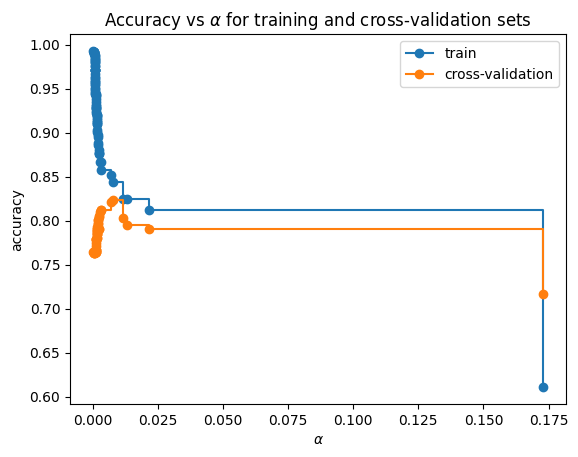

In [ ]:
train_scores = [clf_i.score(X_train_prepd, y_train) for clf_i in clfs]
fig, ax = plt.subplots(dpi=100)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("accuracy")
ax.set_title(r"Accuracy vs $\alpha$ for training and cross-validation sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, grid_search.cv_results_['mean_test_score'], marker="o", label="cross-validation", drawstyle="steps-post")
ax.legend()
plt.show()

Note: we have fewer than 100 $α$ values, so we could apply the grid search to evaluate all of them. If we had hundreds or thousands of $α$'s, we may have to resort to random search because we can't evaluate them all. One can sample from loguniform from the range of $α$ values or simply uniformly sample from the  $α$'s obtained from cost complexity pruning. They'll likely give similar result.

We have a relatively narrow range of alpha values with near best performances. Let's test the tree that corresponds to the best $α$:

Test accuracy was 79.91%.


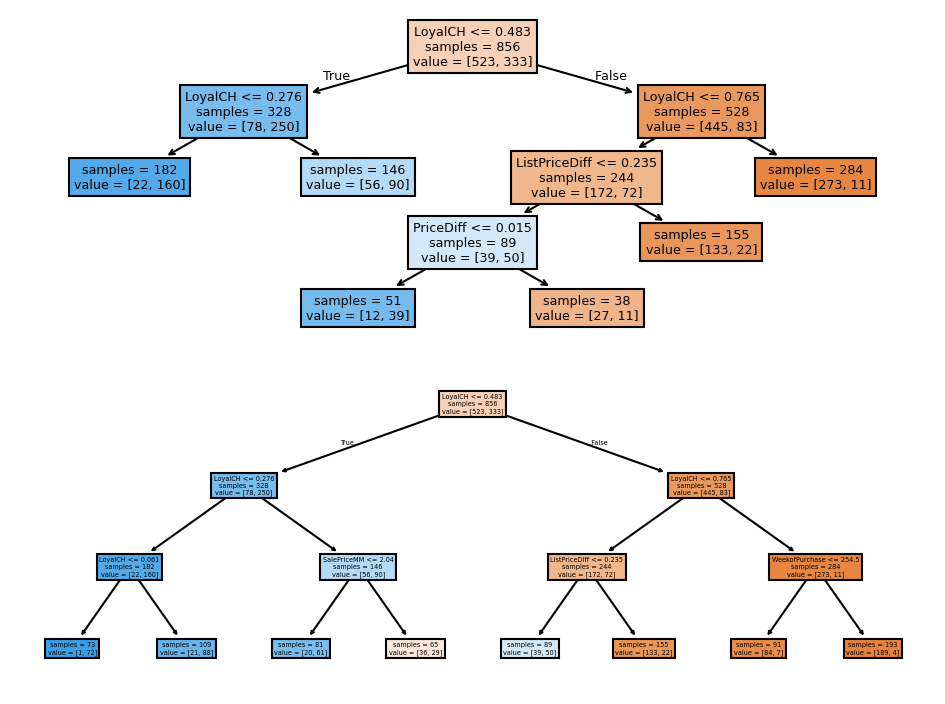

In [ ]:
from sklearn.metrics import accuracy_score

fig, ax = plt.subplots(2, 1, dpi=150)
plot_tree(best_tree, filled=True, feature_names=list(X_train_prepd.columns), impurity=False, ax=ax[0]) # optimal
plot_tree(clf, filled=True, feature_names=list(X_train_prepd.columns), impurity=False, ax=ax[1]) # initial
fig.tight_layout()

print(f'Test accuracy was {accuracy_score(y_test, best_tree.predict(X_test_prepd)):2.2%}.')


The structure we got by imposing an $α$ is rather different than what we got by the max_depth=3 setting earlier. But, they share a common root subtree. I.e., one can be obtained from the other by splitting or merging some nodes. Existing split variable/points don't change; records don't get moved from one region to another: they are simply grouped together or split apart as we go from one tree to another.

## Decision tree regression (Exercise)

In this exercise: apply the decision tree approach to predict house price in Boston suburbs. The data descriptions are [here](https://rdrr.io/cran/ISLR2/man/Boston.html). You can get the data file `Boston.csv` from [this folder](https://drive.google.com/drive/folders/1zBspK0RqCUqVG0ixHKLmfknwF0UTbr6o?usp=sharing)

Boston Data Description

A data set containing housing values in 506 suburbs of Boston.

1. `crim`: per capita crime rate by town.
1. `zn`: proportion of residential land zoned for lots over 25,000 sq.ft.
1. `indus`: proportion of non-retail business acres per town.
1. `chas`: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
1. `nox`: nitrogen oxides concentration (parts per 10 million).
1. `rm`: average number of rooms per dwelling.
1. `age`: proportion of owner-occupied units built prior to 1940.
1. `dis`: weighted mean of distances to five Boston employment centres.
1. `rad`: index of accessibility to radial highways.
1. `tax`: full-value property-tax rate per \$10,000.
1. `ptratio`: pupil-teacher ratio by town.
1. `lstat`: the percentage of individuals with lower socioeconomic status.
1. `medv` (**target**): median value of owner-occupied homes in $1000s.

Do the following on your own:
1. Load, explore, and split data
1. Learn a small decision tree. What are the important variables? What do the nodes in the tree tell you?
1. Find the $α$ values at which the structure of the tree changes.
1. Evaluate the $α$ values through cross validation to determine the tree that leads to highest out-of-sample $R^2$.
1. Evaluate it on the test data set aside earlier.
    1. What test data $R^2$ are you able to achieve?
    1. Any other observations?



In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# drive_url = 'https://drive.google.com/file/d/1YiwMCQSxfD4ZVKCPzHUNl5ocdcvYXeZd/view?usp=drive_link'
file_url = 'https://drive.google.com/uc?id=1ZWbYmBOhbCpPfHKN6UdGR8hr9LmFZ2I6'
rawdata = pd.read_csv(file_url)
rawdata.head()

,Unnamed: 0,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [14]:
data = rawdata.astype({'chas': 'category'})
data.drop(['Unnamed: 0'], axis=1, inplace=True) # drop columns with same/similar information
data.info() # check data
print(data['medv'].value_counts()) # check class distribution
data.head() # take a look at the top 5 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   crim     506 non-null    float64 
 1   zn       506 non-null    float64 
 2   indus    506 non-null    float64 
 3   chas     506 non-null    category
 4   nox      506 non-null    float64 
 5   rm       506 non-null    float64 
 6   age      506 non-null    float64 
 7   dis      506 non-null    float64 
 8   rad      506 non-null    int64   
 9   tax      506 non-null    int64   
 10  ptratio  506 non-null    float64 
 11  lstat    506 non-null    float64 
 12  medv     506 non-null    float64 
dtypes: category(1), float64(10), int64(2)
memory usage: 48.2 KB
medv
50.0    16
25.0     8
23.1     7
22.0     7
21.7     7
        ..
12.6     1
16.4     1
17.7     1
12.0     1
8.1      1
Name: count, Length: 229, dtype: int64


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [12]:
from sklearn.model_selection import train_test_split
X = data.drop('medv', axis=1) # separate X ...
y = data['medv'].copy()       # from y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42) #split all
X_train.shape, X_test.shape, y_train.shape, y_test.shape # check sizes

((404, 12), (102, 12), (404,), (102,))

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn import set_config
set_config(display='diagram') # shows the pipeline graphically when printed

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
    ])

cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('cat_encoder', OneHotEncoder(sparse_output=False))])

prep_pipeline = ColumnTransformer([
    ('num', num_pipeline, make_column_selector(dtype_include=np.number)),
    ('cat', cat_pipeline, make_column_selector(dtype_include='category'))
    ], verbose_feature_names_out=False)

prep_pipeline.set_output(transform='pandas') # output as a pandas dataframe instead of numpy array

X_train_prepd = prep_pipeline.fit_transform(X_train)
X_test_prepd = prep_pipeline.transform(X_test)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn import set_config
set_config(display='diagram') # shows the pipeline graphically when printed

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
    ])
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('cat_encoder', OneHotEncoder(sparse_output=False))
    ])

prep_pipeline = ColumnTransformer([
    ('num', num_pipeline, make_column_selector(dtype_include=np.number)),
    ('cat', cat_pipeline, make_column_selector(dtype_include='category'))
], verbose_feature_names_out=False) # don't prepend the column names with step labels (cleaner)
prep_pipeline.set_output(transform='pandas') # output as a pandas dataframe instead of numpy array

# We apply the preprocessing as a separate step and work with the transformed data
X_train_prepd = prep_pipeline.fit_transform(X_train)

# preprocess the X_test as well
X_test_prepd = prep_pipeline.transform(X_test)


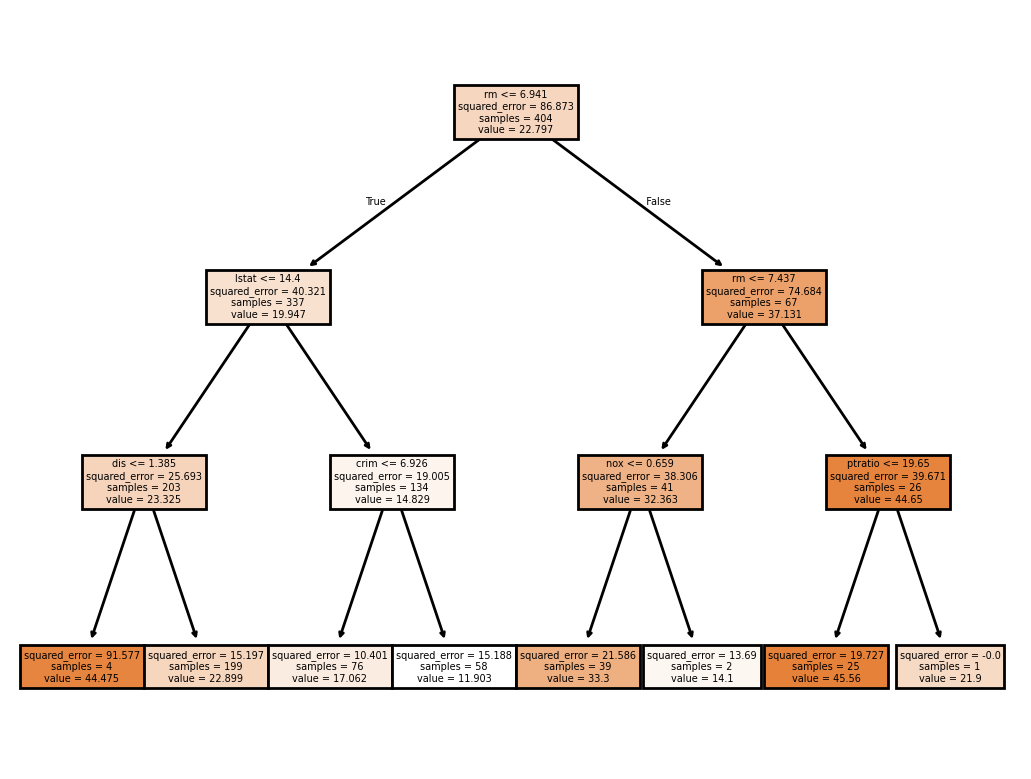

In [17]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.pipeline import make_pipeline

clf = DecisionTreeRegressor(max_depth=3) # Changed to DecisionTreeRegressor

clf.fit(X_train_prepd, y_train)

# print(clf.classes_) # Removed: Regressors do not have classes
plt.figure(dpi=200) # Makes the figure a little larger, easier to read
plot_tree(clf, filled=True, feature_names=list(X_train_prepd.columns)); # graphically shows the tree